In [1]:
# Import python packages that are used here
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob
import cmath as cm
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from glob import glob
from matplotlib.pyplot import figure
import os
import sys


In [2]:
import skrf as rf

In [47]:
root_path = r'/Users/itungchen/UW_lab_data/'
dir_name =  root_path + '/20231206-AlScN-SOS//'

# Define the sort function of the frequency domain data
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[4:-12])

file_name = ['B0.s2p']
B0_4K = rf.Network(dir_name + file_name[0])
B0_RT = rf.Network(dir_name + 'alscn_1p2um.s2p')

# # Grab file name and store in DL list
# DL_4K_S11 = glob(dir_name + '35K-*-S11-pol.prn')
# DL_4K_S11.sort(key = sortKeyFunc_FD)



In [50]:
B0_4K
B0_RT

2-Port Network: 'alscn_1p2um',  300000.0-1500000000.0 Hz, 20001 pts, z0=[50.+0.j 50.+0.j]

In [5]:
from pylab import *
#rf.stylely()

# Getting Started with skrf
Plot commands:

    Network.plot_s_re

    Network.plot_s_im

    Network.plot_s_mag

    Network.plot_s_db

Text(37.525, 0.5, 'S11 (dB)')

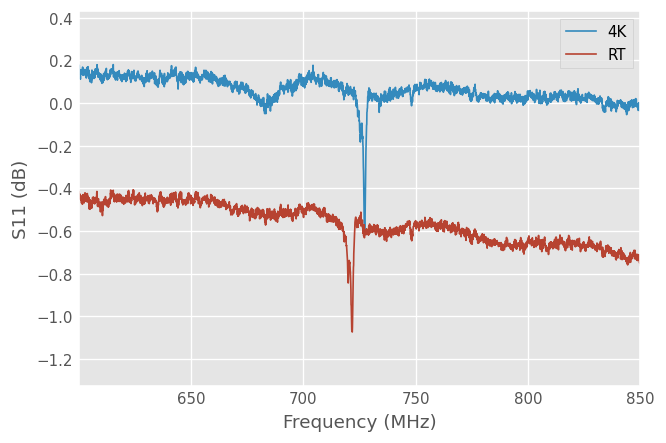

In [56]:
B0_RT.frequency.unit = 'mhz'
B0_4K.s22['600-850mhz'].plot_s_db(label='4K')
B0_RT.s22['600-850mhz'].plot_s_db(label='RT')
plt.ylabel('S11 (dB)')

In [68]:
B0_RT.s[:,0,0] # s11

20001

In [69]:
B0_RT.f # access frequency array

array([3.00000000e+05, 3.74985000e+05, 4.49970000e+05, ...,
       1.49985003e+09, 1.49992502e+09, 1.50000000e+09])

In [74]:
B0_RT.s_time[:,1,0] # access time component of s12

array([ 8.39882197e-07-2.83864642e-07j, -2.21115263e-06-4.19497153e-07j,
       -4.04696835e-07-1.39263711e-07j, ...,
       -1.79915228e-06-4.57882921e-07j,  2.23302922e-07+1.38196116e-06j,
        5.95170014e-07+1.63997841e-06j])

(-500.0, 2000.0)

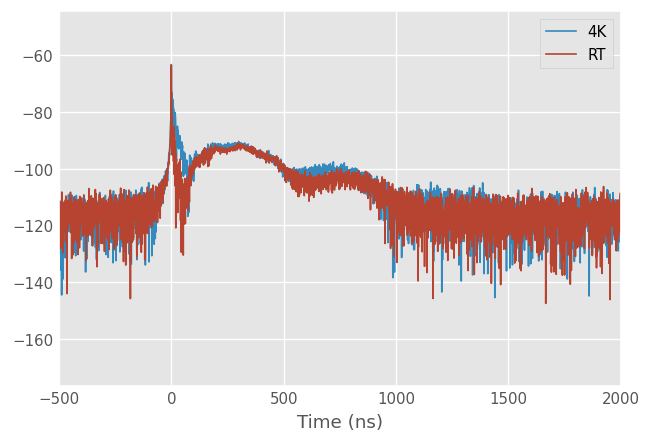

In [84]:
B0_4K.s21.plot_s_time_db(label='4K')
B0_RT.s21.plot_s_time_db(label='RT')
plt.xlim(-500,2000)

In [61]:
B0_RT.s[:,0,0] # s11

array([1.01541  -1.028120e-02j, 0.9984591-6.621263e-03j,
       0.9861077+1.521565e-04j, ..., 0.7168684-5.420626e-01j,
       0.7160732-5.420486e-01j, 0.7144063-5.427919e-01j])

Text(32.775, 0.5, 'S11 (dB)')

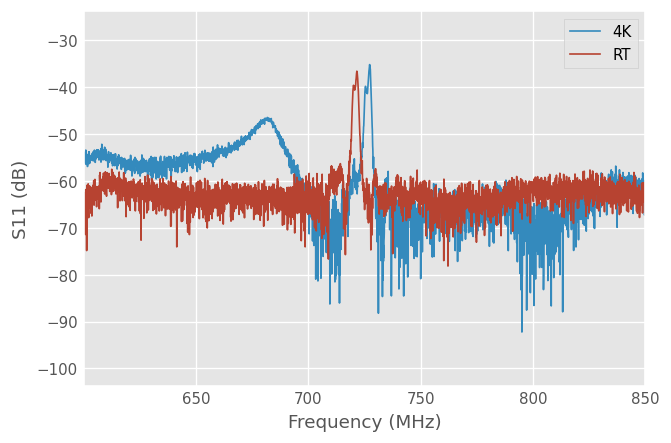

In [57]:
B0_RT.frequency.unit = 'mhz'
B0_4K.s21['600-850mhz'].plot_s_db(label='4K')
B0_RT.s21['600-850mhz'].plot_s_db(label='RT')
plt.ylabel('S11 (dB)')

# Analyzing S11 efficiency

Define the BVD model first:

In [87]:
# Modified BVD model excluding the admittance Ya(omega) but including the series inductive lump elements
def modified_BVD_model_background(freq, Ls, Rs, Rp, Cp):
    """
    Calculates the modified BVD model for resonance.

    Parameters:
    - freq (array-like): Array of frequencies.
    - Lm (float): Inductance value in nH.
    - Cm (float): Capacitance value in nF.
    - Rm (float): Resistance value in Ohms.

    Returns:
    - Y (complex): Admittance value, a complex number.

    """

    jOmega = 1j*2*np.pi*np.array(freq)

    # Refer the circuit model to the reference paper: (doi/10.1002/adma.202305434)

    Ls = Ls*1e-9 

    Cp= Cp*1e-9 
    
    Zp =  1/(jOmega*Cp + 1/Rp)
    
    return jOmega * Ls + Rs + Zp 

def modified_BVD_model_resonance(freq, Lm, Cm, Rm):

    """
    This function calculates the admittance of a modified Butterworth-Van Dyke (BVD) model at resonance.

    Parameters:
    freq (array-like): The frequencies at which to calculate the admittance.
    Lm (float): The motional inductance in nH.
    Cm (float): The motional capacitance in fF.
    Rm (float): The motional resistance in Ohms.

    Returns:
    complex: The admittance at the given frequencies.

    Note:
    The function converts the input parameters to SI units before calculation.
    The return value is a complex number representing the admittance.
    """
     
    # Convert the unit to SI unit 
    Cm = Cm*1e-14 #F
    Lm = Lm*1e-9 #H
    
    # Calculate the angular frequency
    Omega = 2*np.pi*np.array(freq) #Rad
    ws = 1/np.sqrt(Lm*Cm) #Rad/s

    # Calculate the admittance Ya
    Y = ( Rm * (Omega * Cm)**2 - 1j * Omega * Cm * ( (Omega/ws)**2 - 1) ) / ( (Rm * Omega * Cm)**2 + ((Omega/ws)**2 - 1)**2 )
    return Y # Is a complex number

In [88]:
def hstack_BVD_for_fit(Z):
    return np.hstack((Z.real, Z.imag))

# Convert the S11 data to impedance
def convert_s11_to_impedance(s11_pol):
    s11_pol = np.array(s11_pol)
    imp_pol = 50 * (1+s11_pol) / (1-s11_pol)
    return imp_pol

# Covert the fitted load to S11 data
def convert_imped_to_s11(impedance):
    impedance = np.array(impedance)
    s11_pol = (impedance - 50) / (impedance + 50)
    return s11_pol

def fit_BVD_model_background(freq, Impedance_data, start1, end1, start2, end2, p0, bounds, ftol, max_nfev,
                                
                                print_params = True):

    # Find the indices of the range in xdata
    start_idx1 = np.argmin(np.abs(freq - start1))
    end_idx1 = np.argmin(np.abs(freq - end1))
    start_idx2 = np.argmin(np.abs(freq - start2))
    end_idx2 = np.argmin(np.abs(freq - end2))

    # Slice xdata and ydata to the two specified ranges and concatenate them
    x_fit = np.concatenate((freq[start_idx1:end_idx1+1], freq[start_idx2:end_idx2+1]))
    y_fit = np.concatenate((Impedance_data[start_idx1:end_idx1+1], Impedance_data[start_idx2:end_idx2+1]))

    # Perform fitting
    popt, _  = curve_fit(lambda freq, Ls, Rs, Rp, Cp:
                        hstack_BVD_for_fit(modified_BVD_model_background(freq, Ls, Rs, Rp, Cp)),
                        x_fit,
                        np.hstack((y_fit.real, y_fit.imag)),
                        p0= p0,
                        bounds = bounds,
                        ftol = ftol)

    Ls, Rs, Rp, Cp = popt[0], popt[1], popt[2], popt[3] 
    
    if print_params == True:
        print('Ls =', popt[0], 'nH')
        print('Rs =', popt[1], 'Ohm')
        print('Rp =', popt[2], 'Ohm')
        print('Cp =', popt[3], 'nF')
        
    imped_fit = modified_BVD_model_background(freq, Ls, Rs, Rp, Cp)
    s11_fit = convert_imped_to_s11(imped_fit)
    return s11_fit, imped_fit, popt



In [89]:
def fit_BVD_model_resonances(freq, Impedance_data,
                            start1, end1, start2, end2,
                            p0, bounds, ftol, bg_params = [0.17, 4.13, 34.19, 3.14e-3], print_params = True):

    # Find the indices of the range in xdata
    start_idx1 = np.argmin(np.abs(freq - start1))
    end_idx1 = np.argmin(np.abs(freq - end1))
    start_idx2 = np.argmin(np.abs(freq - start2))
    end_idx2 = np.argmin(np.abs(freq - end2))

    # Slice xdata and ydata to the two specified ranges and concatenate them
    Freq_fit = np.concatenate((freq[start_idx1:end_idx1 + 1], freq[start_idx2:end_idx2 + 1]))
    Admittance_fit = 1/np.concatenate((Impedance_data[start_idx1:end_idx1 + 1], Impedance_data[start_idx2:end_idx2 + 1]))

    # Rs, R0, and C0 units are Ohm, Ohm, and nF. 
    #L0, Rs, R0, C0 = bg_params[0]*1e-9, bg_params[1]-1.1, bg_params[2], (bg_params[3]-1e-4)*1e-9
    Ls, Rs, Rp, Cp = bg_params[0] * 1e-9, bg_params[1], bg_params[2], (bg_params[3]) * 1e-9
    def Z0_para(freq, Rp, Cp):
        Omega = 2*np.pi*np.array(freq) #Rad
        return np.array(1 / (1 / Rp + 1j * Omega * Cp))
    
    # Perform fitting
    popt, _  = curve_fit(lambda f, Lm1, Cm1, Rm1:
                        hstack_BVD_for_fit(1/( 2 * np.pi * np.array(f) * Ls 
                                               + Rs 
                                               + 1/(1/Z0_para(f, Rp, Cp) 
                                               + modified_BVD_model_resonance(f, Lm1, Cm1, Rm1)
                                               )
                                               )
                                          ),
                        Freq_fit,
                        np.hstack((Admittance_fit.real, Admittance_fit.imag)),
                        p0= p0,
                        bounds = bounds,
                        ftol = ftol)

    # Assign the fitted parameters
    Lm1, Cm1, Rm1 = popt[0], popt[1], popt[2]
    
    # Calculate the admittance of the 4 resonances
    jOmega = 1j * 2 * np.pi * np.array(freq)
    Y1 = modified_BVD_model_resonance(freq, Lm1, Cm1, Rm1)
    Y_N = Y1 
    Y_list = [Y1]
    # Calculate the total impedance
    Z_total = jOmega * Ls + Rs + 1 / (1 / Z0_para(freq, Rp, Cp) + Y_N)
    
    # Convert impedance to s11
    s11_fit = convert_imped_to_s11(Z_total)
    
    if print_params == True:
        print(popt)
    
    return s11_fit, Z_total, popt, Y_list

In [90]:
def plot_fit(freq, Impedance_data, imped_fit, s11_pol, s11_fit):
    fig = plt.figure(figsize=(12,5))
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.plot(freq, Impedance_data.real, label = 'data_real')
    ax1.plot(freq, (imped_fit).real, label = 'fit_real')
    ax1.plot(freq, Impedance_data.imag, label = 'data_imag')
    ax1.plot(freq, (imped_fit).imag, label = 'fit_imag')

    ax2.plot(freq, abs(Impedance_data), label ='Z_0 data')
    ax2.plot(freq, abs(imped_fit), label ='Z_0 data')

    ax3.plot(freq, s11_pol.real, label = 'data_real')
    ax3.plot(freq, (s11_fit).real, label = 'fit_real')
    ax3.plot(freq, s11_pol.imag, label = 'data_imag')
    ax3.plot(freq, (s11_fit).imag, label = 'fit_imag')

    ax4.plot(freq, abs(s11_pol), label ='Z_0 data')
    ax4.plot(freq, abs(s11_fit), label ='Z_0 fit')

    fig.tight_layout()

Ls = 0.010000000000000002 nH
Rs = 26.21557593912747 Ohm
Rp = 16780.44737598059 Ohm
Cp = 0.0008119105074711225 nF
[2.18369677e-02 9.20224780e-08 1.96614265e+02]


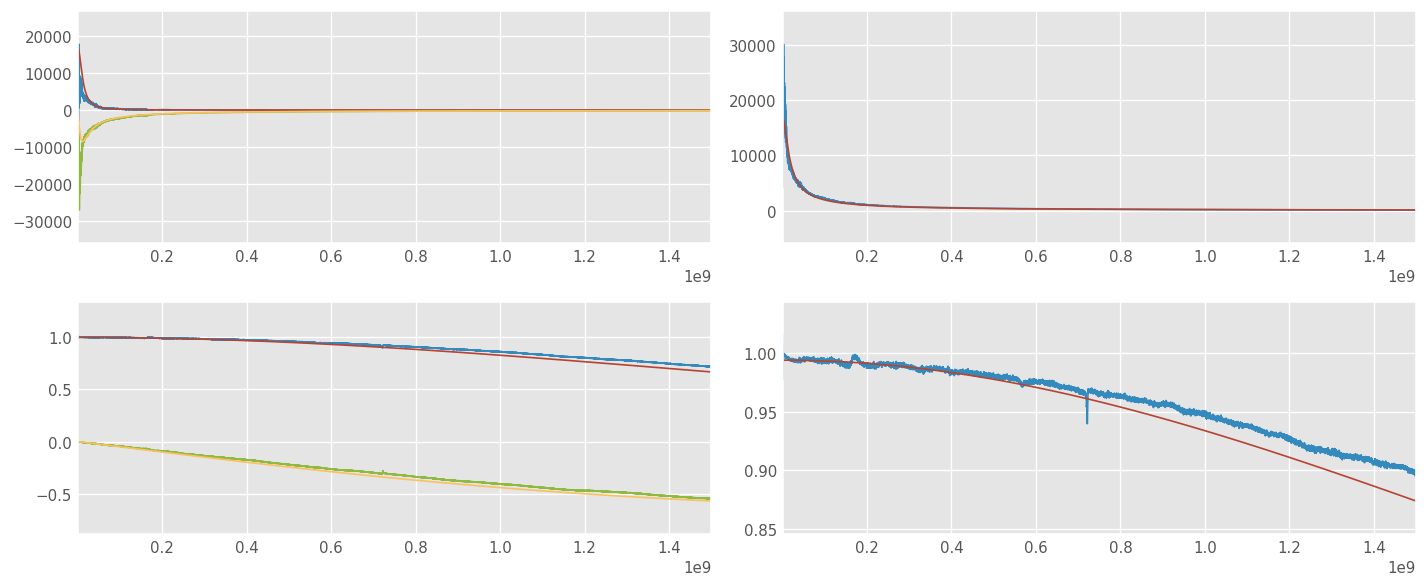

In [322]:
# Load the data from the imported network in skrf
s11_pol = B0_RT.s[:,0,0]
freq = B0_RT.f
plot = True

# Define the fitting range
start_bg, end_bg = 0.02e9, 0.5e9 #Hz
start_bg2, end_bg2 = 0.8e9, 1.2e9
start_reso, end_reso = 0.6e9, 0.7e9
start_reso2, end_reso2 = 0.7e9, 0.8e9

# Define the initial fitting params
p0_bg = [0.2, 1e-6, 500, 1e-2]
p0_reso = [10, 1, 1000] # Lm, Cm, Rm

# Set bounds on the parameters
bounds_bg = ((1e-2, 1e-10, 0, 1e-5), (200, np.inf, np.inf, 10)) # Ls, Rs, Rp. Cp
bounds_reso = ((0, 0, 0), (200, 30, 5000)) # Lm, Cm, Rm

# Set tolerance
ftol = 1e-7
max_nfev = 1e10

# Actual fitting functions below
Impedance_data = convert_s11_to_impedance(s11_pol)

try:
    _, _, BG_fit_params = fit_BVD_model_background(freq, Impedance_data, start_bg, end_bg, start_bg2, end_bg2, p0_bg, bounds_bg, ftol, max_nfev)
    s11_fit, Z_total, popt, Y_list   = fit_BVD_model_resonances(freq, Impedance_data,
                                                                    start_reso, end_reso, start_reso2, end_reso2,
                                                                    p0_reso, bounds_reso, ftol, bg_params = BG_fit_params, print_params = True)
    
    if plot == True:
        plot_fit(freq, Impedance_data, Z_total, s11_pol, s11_fit)

except:
    print('Fit failed')

[1.00000000e-02 1.00000000e-10 6.81574739e+10 9.38770834e-04]


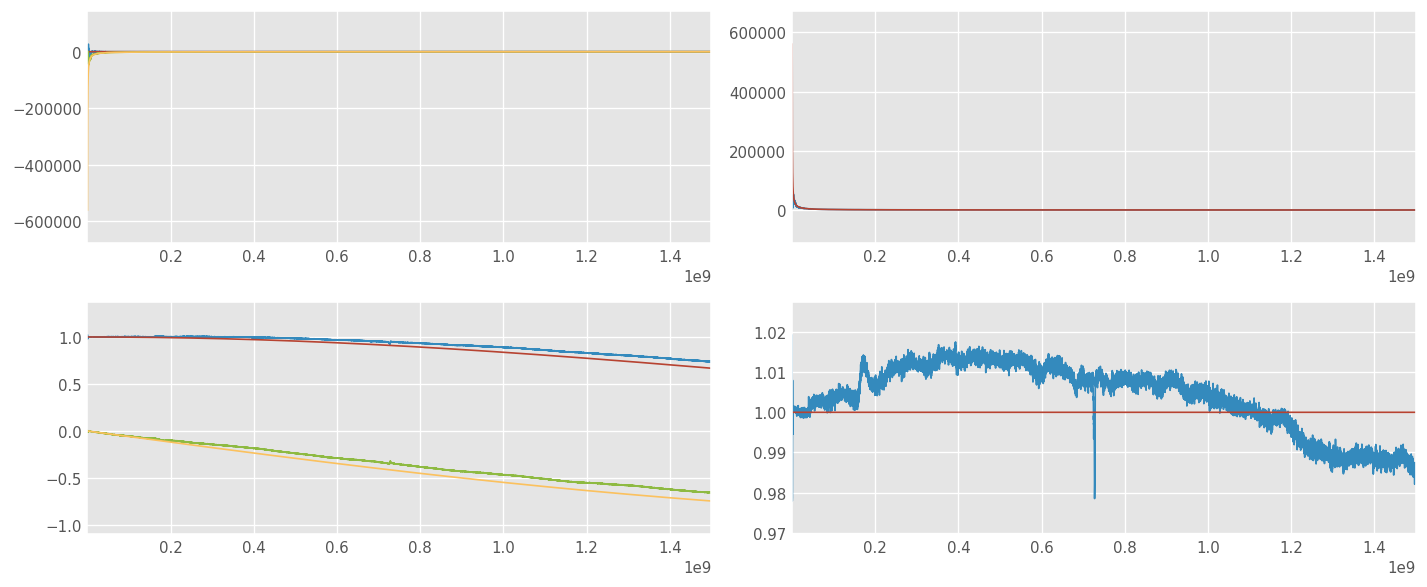

In [200]:
print(BG_fit_params)
#Fit_params_4K = [0.1e-1, 6, 0.6e2, 1.5e-3]

# Generate some example frequency
Y3 = modified_BVD_model_resonance(freq, Lm=0.01, Cm=0.8, Rm=1) # Signal at 4.8 GHz

# Calculate Z0
jOmega = 1j * 2 * np.pi * freq
Ls, Rs, Rp, Cp = BG_fit_params[0] * 1e-9, BG_fit_params[1], BG_fit_params[2], (BG_fit_params[3]) * 1e-9 
Z0 = np.array(1/(1 / Rp + jOmega * Cp)) 

# Calculate the N combined admittances
Y_N = Y3

# Calculate the total impedance
Z_total = jOmega * Ls + Rs + 1/(1/Z0 + Y_N)  

# Calculate the total impedance
Y_total = 1 / Z_total 

# Calculate the S11 from total impedance
s11_fit = convert_imped_to_s11(Z_total)

# Plot the fitted admittance and the S11
plot_fit(freq, Impedance_data, Z_total, s11_pol, s11_fit)

#Save the variables for supporting figures
freq_sup = freq
Z_sup = Impedance_data
Z_fit_sup = Z_total
S11_data_sup = s11_pol
S11_fit_sup = s11_fit

# Time-domain analysis

In [210]:
root_path = r'/Users/itungchen/UW_lab_data/'
dir_name =  root_path + '/20231206-AlScN-SOS//'

# Define the sort function of the frequency domain data
def sortdata(s):
    return int(os.path.basename(s)[1:-4])

B_data_list = glob(dir_name + 'B*.s2p')
B_data_list.sort(key = sortdata)

# Load the data to netowrk list
B_ntwk_list = []
for B in B_data_list:
    B_ntwk_list.append(rf.Network(B))

Text(61.574999999999996, 0.5, 'S21 (dB)')

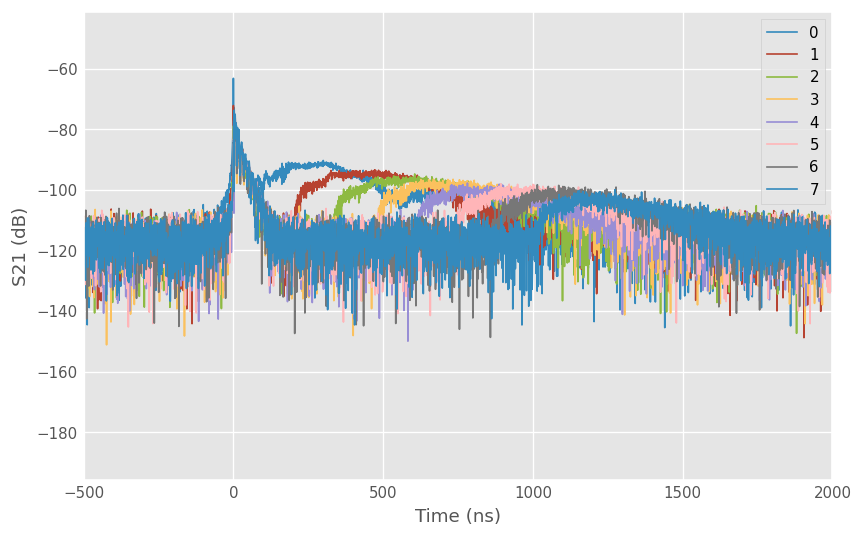

In [233]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list[i].s21.plot_s_time_db(label=i, ax = ax1)

ax1.set_xlim(-500,2000)
ax1.set_ylabel('S21 (dB)')

Text(61.574999999999996, 0.5, 'S21 (dB)')

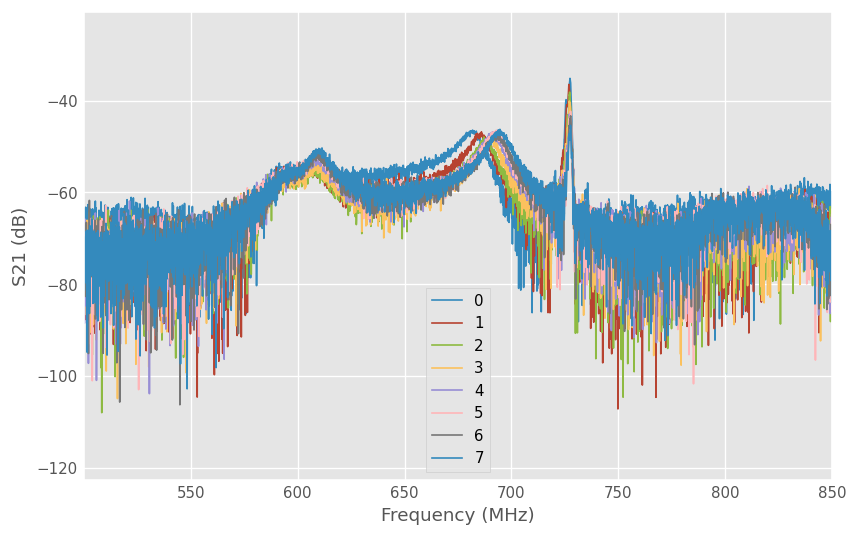

In [231]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list[i].frequency.unit = 'mhz'
    B_ntwk_list[i].s21['500-850mhz'].plot_s_db(label=i, ax = ax1)

ax1.set_ylabel('S21 (dB)')

Text(61.574999999999996, 0.5, 'S21 (dB)')

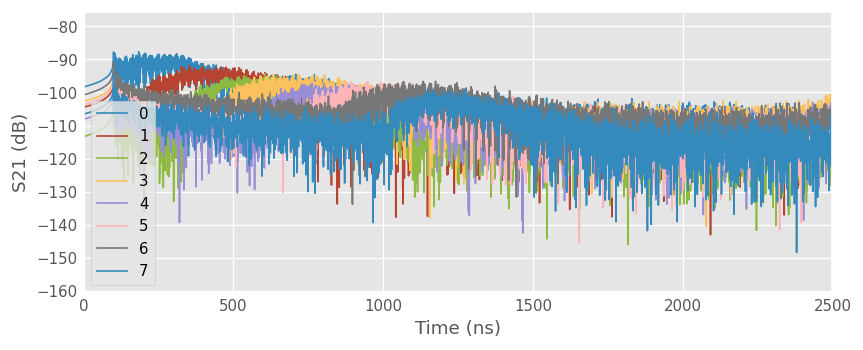

In [326]:
# Perform time-gating on each nework data
B_ntwk_list_gate = []
for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate.append(rf.time.time_gate(B_ntwk_list[i].s21, 100, 2500, t_unit='ns', window = 'boxcar'))

fig = plt.figure(figsize=(8,3))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i].plot_s_time_db(label=i, ax = ax1)

ax1.set_xlim(0,2500)
ax1.set_ylabel('S21 (dB)')

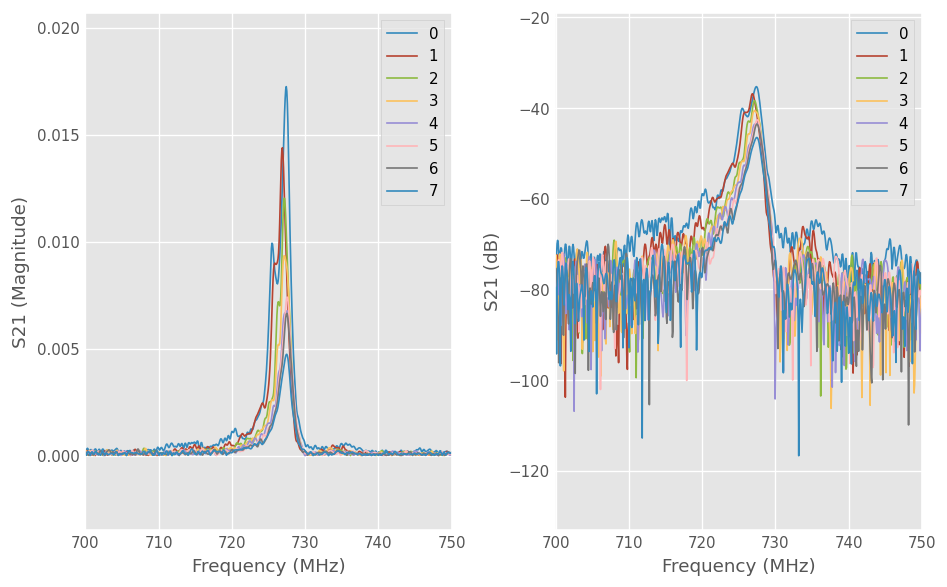

In [330]:
# Plot the time-gated data
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i]['700-750mhz'].plot_s_mag(label=i, ax = ax1)
    B_ntwk_list_gate[i]['700-750mhz'].plot_s_db(label=i, ax = ax2)

ax1.set_ylabel('S21 (Magnitude)')
ax2.set_ylabel('S21 (dB)')
fig.tight_layout()


In [262]:
B_ntwk_list_gate[0].s[:,0,0]

array([0.00879565+0.0022632j , 0.00240385+0.00079906j,
       0.0012566 +0.00072533j, ..., 0.001309  +0.00088056j,
       0.00202786+0.00099455j, 0.0033405 +0.00111559j])

In [305]:
import scipy
scipy.signal.get_window(('boxcar'), 2000)

array([1., 1., 1., ..., 1., 1., 1.])

Text(61.574999999999996, 0.5, 'S21 (dB)')

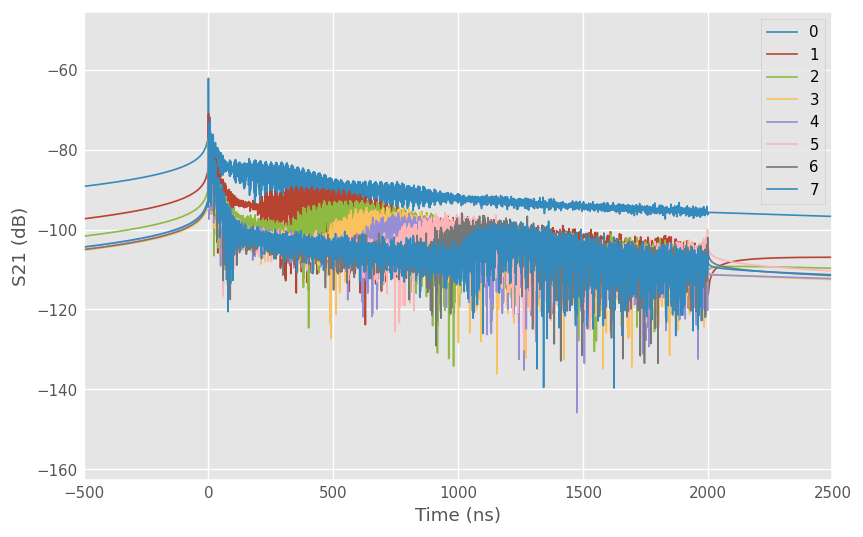

In [307]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i].plot_s_time_db(label=i, ax = ax1)

ax1.set_xlim(-500,2500)
ax1.set_ylabel('S21 (dB)')

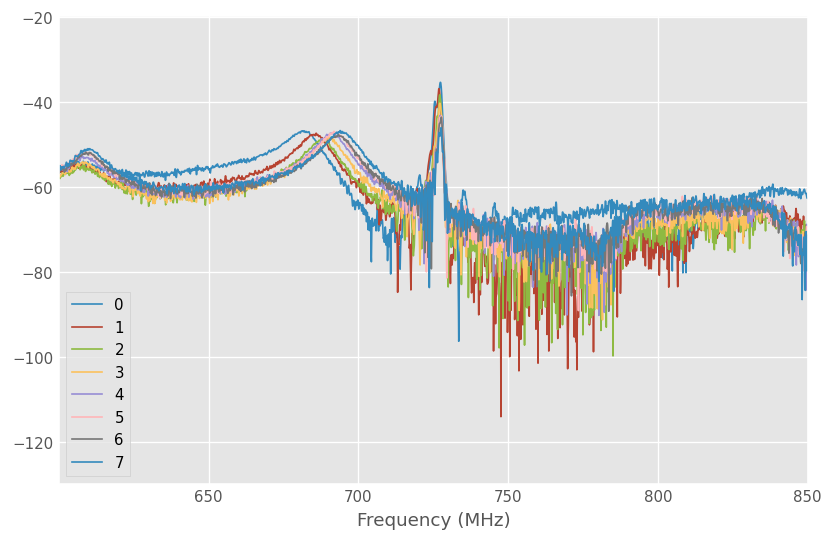

In [294]:
# Plot the time-gated data
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)
for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i]['600-850mhz'].plot_s_db(label=i, ax = ax1)

